In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# from cats2d.rd_cats2d import CATS2D
from pubchempy import *
from rdkit.Avalon import pyAvalonTools
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors, MACCSkeys, GraphDescriptors, Lipinski, QED, rdMolDescriptors, Fragments, FragmentMatcher
from rdkit.Chem.EState.EState_VSA import VSA_EState_
from statistics import mean
from tqdm import tqdm

In [4]:
import sklearn
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error

In [5]:
df = pd.read_csv('classification_dataset.csv')
df.head()

,SMILES,Activity,Agglomeration,SMILES_clear,ROMol,FORMAL_CHARGE_ch,SMILES_uncharge,FORMAL_CHARGE_unch
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,0,False,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,<rdkit.Chem.rdchem.Mol object at 0x00000208672...,0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,0,False,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x00000208672...,0,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0
2,Oc1c(I)cc(Cl)c2cccnc12,0,False,Oc1c(I)cc(Cl)c2cccnc12,<rdkit.Chem.rdchem.Mol object at 0x00000208672...,0,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,0,False,CCNC(=NCCSCc1ncccc1Br)NC#N,<rdkit.Chem.rdchem.Mol object at 0x00000208672...,0,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,0,False,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,<rdkit.Chem.rdchem.Mol object at 0x00000208672...,0,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0


In [6]:
df = df[['SMILES_uncharge', 'Activity']]


In [7]:
df = df.rename(columns={'SMILES_uncharge':'SMILES', 'logBB':'Activity'})
df.head()

,SMILES,Activity
0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0
1,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0
2,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0
3,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0
4,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0


### QED and Crippen modules

In [8]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    qed_vector = QED.properties(mol)
    df.at[i, 'MW'] = round(qed_vector[0], 2)
    df.at[i, 'AlogP'] = round(qed_vector[1], 2)
    df.at[i, '#HBA'] = qed_vector[2]
    df.at[i, '#HBD'] = qed_vector[3]
    df.at[i, 'PSA'] = qed_vector[4]
    df.at[i, '#ROTB'] = qed_vector[5]
    df.at[i, '#ALERTS'] = qed_vector[7]
    
    df.at[i, 'MlogP'] = round(Crippen.MolLogP(mol), 2)
    df.at[i, '#MR'] = round(Crippen.MolMR(mol), 2)
    
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR
0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0,398.40,3.70,6.0,3.0,141.31,6.0,1.0,3.70,100.73
1,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0,520.48,-1.13,13.0,4.0,206.30,9.0,4.0,-1.13,117.14
2,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0,305.50,3.20,2.0,1.0,33.12,0.0,1.0,3.20,61.13
3,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0,342.27,2.11,5.0,2.0,73.10,6.0,5.0,2.11,82.83
4,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0,461.47,-1.24,10.0,5.0,149.15,3.0,1.0,-1.24,110.86


### Lipinski module

In [9]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, '#HeavyAtoms'] = Lipinski.HeavyAtomCount(mol)
    df.at[i, '#NHOH'] = Lipinski.NHOHCount(mol)
    df.at[i, '#NO'] = Lipinski.NOCount(mol)
    df.at[i, '#AromaticCarbocycles'] = Lipinski.NumAromaticCarbocycles(mol)
    df.at[i, '#AromaticHeterocycles'] = Lipinski.NumAromaticHeterocycles(mol)
    df.at[i, '#Heteroatoms'] = Lipinski.NumHeteroatoms(mol)
    
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,#NHOH,#NO,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms
0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0,398.40,3.70,6.0,3.0,141.31,6.0,1.0,3.70,100.73,28.0,3.0,9.0,2.0,1.0,10.0
1,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0,520.48,-1.13,13.0,4.0,206.30,9.0,4.0,-1.13,117.14,36.0,4.0,15.0,1.0,1.0,16.0
2,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0,305.50,3.20,2.0,1.0,33.12,0.0,1.0,3.20,61.13,13.0,1.0,2.0,1.0,1.0,4.0
3,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0,342.27,2.11,5.0,2.0,73.10,6.0,5.0,2.11,82.83,19.0,2.0,5.0,0.0,1.0,7.0
4,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0,461.47,-1.24,10.0,5.0,149.15,3.0,1.0,-1.24,110.86,33.0,5.0,10.0,1.0,0.0,10.0


### Descriptors module

In [10]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'Morgan2'] =  round(Descriptors.FpDensityMorgan2(mol), 2)
    df.at[i, 'Morgan3'] =  round(Descriptors.FpDensityMorgan3(mol), 2)
    df.at[i, 'HeavyAtomMW'] =  round(Descriptors.HeavyAtomMolWt(mol), 2)
    df.at[i, 'MaxPartialCharge'] = Descriptors.MaxPartialCharge(mol)
    df.at[i, 'MinPartialCharge'] = Descriptors.MinPartialCharge(mol)
    df.at[i, '#ValenceElectrons'] = Descriptors.NumValenceElectrons(mol)
    
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,#NO,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons
0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0,398.40,3.70,6.0,3.0,141.31,6.0,1.0,3.70,...,9.0,2.0,1.0,10.0,1.64,2.29,384.29,0.339051,-0.507050,142.0
1,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0,520.48,-1.13,13.0,4.0,206.30,9.0,4.0,-1.13,...,15.0,1.0,1.0,16.0,2.00,2.56,500.32,0.352266,-0.507967,190.0
2,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0,305.50,3.20,2.0,1.0,33.12,0.0,1.0,3.20,...,2.0,1.0,1.0,4.0,2.23,3.00,300.46,0.154758,-0.504591,66.0
3,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0,342.27,2.11,5.0,2.0,73.10,6.0,5.0,2.11,...,5.0,0.0,1.0,7.0,2.47,3.16,326.14,0.204213,-0.355850,102.0
4,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0,461.47,-1.24,10.0,5.0,149.15,3.0,1.0,-1.24,...,10.0,1.0,0.0,10.0,1.94,2.70,434.25,0.335335,-0.482190,178.0


### GraphDescriptors module

In [11]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'BertzCT'] = round(GraphDescriptors.BertzCT(mol), 2)
    df.at[i, 'Kappa1'] = round(GraphDescriptors.Kappa1(mol), 2)
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons,BertzCT,Kappa1
0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0,398.40,3.70,6.0,3.0,141.31,6.0,1.0,3.70,...,1.0,10.0,1.64,2.29,384.29,0.339051,-0.507050,142.0,1130.40,18.99
1,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0,520.48,-1.13,13.0,4.0,206.30,9.0,4.0,-1.13,...,1.0,16.0,2.00,2.56,500.32,0.352266,-0.507967,190.0,1262.62,25.08
2,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0,305.50,3.20,2.0,1.0,33.12,0.0,1.0,3.20,...,1.0,4.0,2.23,3.00,300.46,0.154758,-0.504591,66.0,472.37,9.02
3,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0,342.27,2.11,5.0,2.0,73.10,6.0,5.0,2.11,...,1.0,7.0,2.47,3.16,326.14,0.204213,-0.355850,102.0,457.68,15.80
4,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0,461.47,-1.24,10.0,5.0,149.15,3.0,1.0,-1.24,...,0.0,10.0,1.94,2.70,434.25,0.335335,-0.482190,178.0,1029.43,21.33


### Fragment descriptors

In [12]:
uniq_el = set([])
uniq_bond = set([])
for mol_sm in tqdm(df['SMILES']):
    mol_sm_rd = Chem.MolFromSmiles(mol_sm)
    list_atomic = [x.GetSymbol() for x in mol_sm_rd.GetAtoms()]
    uniq_el = uniq_el | set(list_atomic)
    list_bond = [str(x.GetBondType()) for x in Chem.MolFromSmiles(mol_sm).GetBonds()]
    uniq_bond = uniq_bond | set(list_bond)
    
uniq_el = list(uniq_el) 
print(uniq_el)
np.save('BBB_uniq_el', np.array(uniq_el))
uniq_bond = list(uniq_bond) 
print(uniq_bond)

100%|████████████████████████████████████████████████████████████████████████████| 7795/7795 [00:04<00:00, 1670.61it/s]

['I', 'Si', 'N', 'O', 'Br', 'B', 'C', 'P', 'F', 'S', 'Cl']
['TRIPLE', 'DOUBLE', 'SINGLE', 'AROMATIC']


In [13]:
list_dop_descript = []
for mol_i in tqdm(df['SMILES']):
    mol_sm = Chem.MolFromSmiles(mol_i)
    
    num_atom = mol_sm.GetNumAtoms()

    # the amount of each element in the molecule
    list_atomic_num = [x.GetSymbol() for x in mol_sm.GetAtoms()]
    list_count_atom = [list_atomic_num.count(x) for x in uniq_el]

    # number of each bond type and bond analysis
    list_bond = list(np.array([x.GetBondType() for x in mol_sm.GetBonds()], dtype=str))
    list_count_bond = [list_bond.count(x) for x in uniq_bond]
    

    AlCOO = Fragments.fr_Al_COO(mol_sm)
    AlOH = Fragments.fr_Al_OH(mol_sm)
    AlOHnt = Fragments.fr_Al_OH_noTert(mol_sm)
    ArN = Fragments.fr_ArN(mol_sm) 
    ArCOO = Fragments.fr_Ar_COO(mol_sm)
    Ar_N = Fragments.fr_Ar_N(mol_sm) 
    ArNH = Fragments.fr_Ar_NH(mol_sm) 
    ArOH = Fragments.fr_Ar_OH(mol_sm)
    COO = Fragments.fr_COO(mol_sm)
    CO = Fragments.fr_C_O(mol_sm)
    CO_clean = Fragments.fr_C_O_noCOO(mol_sm)
    CS = Fragments.fr_C_S(mol_sm)
    HOCCN = Fragments.fr_HOCCN(mol_sm)
    Imine = Fragments.fr_Imine(mol_sm)
    NHtert = Fragments.fr_NH0(mol_sm)
    NHsec = Fragments.fr_NH1(mol_sm)
    NHpri = Fragments.fr_NH2(mol_sm)
    NO = Fragments.fr_N_O(mol_sm) 
    XCCNR = Fragments.fr_Ndealkylation1(mol_sm) 
    TACA = Fragments.fr_Ndealkylation2(mol_sm) 
    Npyrrl = Fragments.fr_Nhpyrrole(mol_sm)
    SH = Fragments.fr_SH(mol_sm)
    Ald = Fragments.fr_aldehyde(mol_sm)
    Alk_carb = Fragments.fr_alkyl_carbamate(mol_sm) 
    Alk_hal = Fragments.fr_alkyl_halide(mol_sm)
    Alk_oxid = Fragments.fr_allylic_oxid(mol_sm)
    Amide = Fragments.fr_amide(mol_sm)
    Amidine = Fragments.fr_amidine(mol_sm)
    Aniline = Fragments.fr_aniline(mol_sm)
    Ar_methyl = Fragments.fr_aryl_methyl(mol_sm) 
    Azide = Fragments.fr_azide(mol_sm)
    Azo = Fragments.fr_azo(mol_sm)
    Barb = Fragments.fr_barbitur(mol_sm)
    Benz = Fragments.fr_benzene(mol_sm)
    BenzD = Fragments.fr_benzodiazepine(mol_sm)
    Bicycl = Fragments.fr_bicyclic(mol_sm)
    Diazo = Fragments.fr_diazo(mol_sm)
    DHpyridine = Fragments.fr_dihydropyridine(mol_sm)
    Epoxide = Fragments.fr_epoxide(mol_sm)
    Ester = Fragments.fr_ester(mol_sm)
    EtherO = Fragments.fr_ether(mol_sm)
    Furan = Fragments.fr_furan(mol_sm)
    Guanid = Fragments.fr_guanido(mol_sm)
    Hal = Fragments.fr_halogen(mol_sm)
    Hdrzine = Fragments.fr_hdrzine(mol_sm)
    Hdrzone = Fragments.fr_hdrzone(mol_sm)
    Imidazole = Fragments.fr_imidazole(mol_sm)
    Imide = Fragments.fr_imide(mol_sm)
    RNCO = Fragments.fr_isocyan(mol_sm)
    RNCS = Fragments.fr_isothiocyan(mol_sm)
    Ket = Fragments.fr_ketone(mol_sm)
    Ket2 = Fragments.fr_ketone_Topliss(mol_sm)
    Lactam = Fragments.fr_lactam(mol_sm)
    Lactone = Fragments.fr_lactone(mol_sm)
    OMe = Fragments.fr_methoxy(mol_sm)
    Morphlne = Fragments.fr_morpholine(mol_sm)
    RCN = Fragments.fr_nitrile(mol_sm)
    Nitro = Fragments.fr_nitro(mol_sm)
    NitroAr = Fragments.fr_nitro_arom(mol_sm)
    NitroArno = Fragments.fr_nitro_arom_nonortho(mol_sm)
    RNO = Fragments.fr_nitroso(mol_sm)
    Oxaz = Fragments.fr_oxazole(mol_sm)
    Oxime = Fragments.fr_oxime(mol_sm)
    paraHX = Fragments.fr_para_hydroxylation(mol_sm)
    PhOH = Fragments.fr_phenol(mol_sm)
    PhOHno = Fragments.fr_phenol_noOrthoHbond(mol_sm)
    PAcide = Fragments.fr_phos_acid(mol_sm)
    PEster = Fragments.fr_phos_ester(mol_sm)
    Piprdn = Fragments.fr_piperdine(mol_sm)
    Piprzn = Fragments.fr_piperzine(mol_sm)
    Priamide = Fragments.fr_priamide(mol_sm)
    Prisulfamd = Fragments.fr_prisulfonamd(mol_sm)
    PyrRing = Fragments.fr_pyridine(mol_sm)
    Nquat = Fragments.fr_quatN(mol_sm)
    Sether = Fragments.fr_sulfide(mol_sm)
    Sulfamd = Fragments.fr_sulfonamd(mol_sm)
    Sulfone = Fragments.fr_sulfone(mol_sm)
    TermCHCH = Fragments.fr_term_acetylene(mol_sm)
    Tetrazol = Fragments.fr_tetrazole(mol_sm)
    Thiazole = Fragments.fr_thiazole(mol_sm)
    RSCN = Fragments.fr_thiocyan(mol_sm)
    Thioph = Fragments.fr_thiophene(mol_sm)
    UNb_alk = Fragments.fr_unbrch_alkane(mol_sm)
    Urea = Fragments.fr_urea(mol_sm)

    
    list_desc = list_count_atom + list_count_bond + [num_atom, 
               AlCOO, AlOH, AlOHnt, ArN, ArCOO, Ar_N, ArNH, ArOH, COO, CO, CO_clean, CS, HOCCN,
               Imine, NHtert, NHsec, NHpri, NO, XCCNR, TACA, Npyrrl, SH, Ald, Alk_carb, Alk_hal,
               Alk_oxid, Amide, Amidine, Aniline, Ar_methyl, Azide, Azo, Barb, Benz, BenzD,
               Bicycl, Diazo, DHpyridine, Epoxide, Ester, EtherO, Furan, Guanid, Hal, Hdrzine,
               Hdrzone, Imidazole, Imide, RNCO, RNCS, Ket, Ket2, Lactam, Lactone, OMe, Morphlne,
               RCN, Nitro, NitroAr, NitroArno, RNO, Oxaz, Oxime, paraHX, PhOH, PhOHno, PAcide,
               PEster, Piprdn, Piprzn, Priamide, Prisulfamd, PyrRing, Nquat, Sether, Sulfamd,
               Sulfone, TermCHCH, Tetrazol, Thiazole, RSCN, Thioph, UNb_alk, Urea]
    list_dop_descript.append(list_desc)
    
list_dop_descript = np.array(list_dop_descript)

100%|█████████████████████████████████████████████████████████████████████████████| 7795/7795 [00:10<00:00, 764.04it/s]


In [14]:
list_dop_descript.shape

(7795, 100)

In [15]:
dop_desc_name = uniq_el + uniq_bond + ['num_atom', 
            'AlCOO', 'AlOH', 'AlOHnt', 'ArN', 'ArCOO', 'Ar_N', 'ArNH', 'ArOH', 'COO',
            'CO', 'CO_clean', 'CS', 'HOCCN',
            'Imine', 'NHtert', 'NHsec', 'NHpri', 'NO', 'XCCNR', 'TACA', 'Npyrrl', 'SH',
            'Ald', 'Alk_carb', 'Alk_hal',
            'Alk_oxid', 'Amide', 'Amidine', 'Aniline', 'Ar_methyl', 'Azide', 'Azo', 'Barb', 'Benz', 'BenzD',
            'Bicycl', 'Diazo', 'DHpyridine', 'Epoxide', 'Ester',
            'EtherO', 'Furan', 'Guanid', 'Hal', 'Hdrzine',
            'Hdrzone', 'Imidazole', 'Imide', 'RNCO', 'RNCS', 'Ket',
            'Ket2', 'Lactam', 'Lactone', 'OMe', 'Morphlne',
            'RCN', 'Nitro', 'NitroAr', 'NitroArno', 'RNO', 'Oxaz', 'Oxime', 'paraHX', 'PhOH', 'PhOHno', 'PAcide',
            'PEster', 'Piprdn', 'Piprzn', 'Priamide', 'Prisulfamd', 'PyrRing', 'Nquat', 'Sether', 'Sulfamd',
            'Sulfone', 'TermCHCH', 'Tetrazol', 'Thiazole', 'RSCN', 'Thioph', 'UNb_alk', 'Urea']

dop_desc_name_new = [str(x) + '_dop' for x in dop_desc_name]
print(dop_desc_name_new)

dop_mass_one = list_dop_descript.copy()
dop_mass_one[dop_mass_one != 0] = 1
dop_mass_one = np.sum(dop_mass_one, axis=0)

['I_dop', 'Si_dop', 'N_dop', 'O_dop', 'Br_dop', 'B_dop', 'C_dop', 'P_dop', 'F_dop', 'S_dop', 'Cl_dop', 'TRIPLE_dop', 'DOUBLE_dop', 'SINGLE_dop', 'AROMATIC_dop', 'num_atom_dop', 'AlCOO_dop', 'AlOH_dop', 'AlOHnt_dop', 'ArN_dop', 'ArCOO_dop', 'Ar_N_dop', 'ArNH_dop', 'ArOH_dop', 'COO_dop', 'CO_dop', 'CO_clean_dop', 'CS_dop', 'HOCCN_dop', 'Imine_dop', 'NHtert_dop', 'NHsec_dop', 'NHpri_dop', 'NO_dop', 'XCCNR_dop', 'TACA_dop', 'Npyrrl_dop', 'SH_dop', 'Ald_dop', 'Alk_carb_dop', 'Alk_hal_dop', 'Alk_oxid_dop', 'Amide_dop', 'Amidine_dop', 'Aniline_dop', 'Ar_methyl_dop', 'Azide_dop', 'Azo_dop', 'Barb_dop', 'Benz_dop', 'BenzD_dop', 'Bicycl_dop', 'Diazo_dop', 'DHpyridine_dop', 'Epoxide_dop', 'Ester_dop', 'EtherO_dop', 'Furan_dop', 'Guanid_dop', 'Hal_dop', 'Hdrzine_dop', 'Hdrzone_dop', 'Imidazole_dop', 'Imide_dop', 'RNCO_dop', 'RNCS_dop', 'Ket_dop', 'Ket2_dop', 'Lactam_dop', 'Lactone_dop', 'OMe_dop', 'Morphlne_dop', 'RCN_dop', 'Nitro_dop', 'NitroAr_dop', 'NitroArno_dop', 'RNO_dop', 'Oxaz_dop', 'Oxime

In [16]:
print(dop_mass_one.shape)
print(dop_mass_one)

(100,)
[  43    1 6322 7060  139    3 7795   53 1119 1866 1261  263 6301 7787
 5750 7795 1043 2964 2583  441  111 1972  497  953 1144 5153 4907   45
  191  399 5022 3327 1533   64 1302 1185  497   16   78   59  955 1538
 2921  133 1703 1081    9    5   69 4956   80 4563    0   19   61 1530
 3881  150   98 2302   73   47  303  260    0    0 1711 1544  743  297
 1234   95  169  130   73   51    9   19  244  903  883  872   17   17
 1199  480  347    0  576   88  995  212  172   69  110  265    0  134
  557  254]


C:\Users\alley\AppData\Local\Temp\ipykernel_25568\1281551338.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(len(dop_mass_one)), np.log10(np.sort(dop_mass_one)))


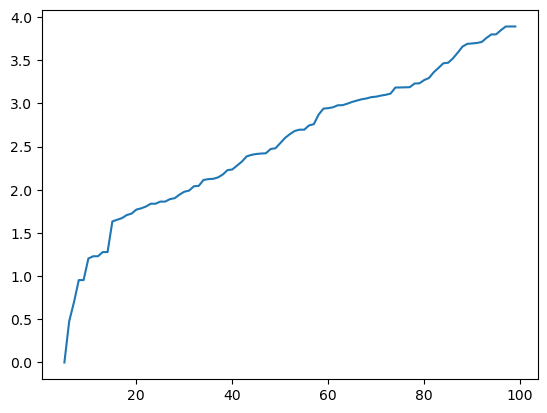

In [17]:
plt.plot(np.arange(len(dop_mass_one)), np.log10(np.sort(dop_mass_one)))

In [18]:
w = np.where(dop_mass_one > 20)[0]
df_dop_desc = pd.DataFrame(list_dop_descript, columns=np.array(dop_desc_name_new, dtype=str)) #first set
print('dop desc', df_dop_desc.shape)
print('left dop feat', len(w))
df_dop_desc = df_dop_desc.iloc[:, w]
print('dop desc new', df_dop_desc.shape)

dop desc (7795, 100)
left dop feat 85
dop desc new (7795, 85)


In [19]:
df_dop_desc['Activity'] = df['Activity'].values
columns = list(df_dop_desc.columns.values)
columns = [columns[-1]] + columns[:-1]
df_dop_desc = df_dop_desc.loc[:, columns]
df_dop_desc.head(5)

,Activity,I_dop,N_dop,O_dop,Br_dop,C_dop,P_dop,F_dop,S_dop,Cl_dop,...,Nquat_dop,Sether_dop,Sulfamd_dop,Sulfone_dop,TermCHCH_dop,Tetrazol_dop,Thiazole_dop,Thioph_dop,UNb_alk_dop,Urea_dop
0,0,0,4,5,0,18,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,6,9,0,20,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,0,1,1,1,0,9,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,5,0,1,12,0,0,1,0,...,0,1,0,0,0,0,0,0,2,0
4,0,0,1,9,0,23,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_corr = df_dop_desc.corr()
df_corr

,Activity,I_dop,N_dop,O_dop,Br_dop,C_dop,P_dop,F_dop,S_dop,Cl_dop,...,Nquat_dop,Sether_dop,Sulfamd_dop,Sulfone_dop,TermCHCH_dop,Tetrazol_dop,Thiazole_dop,Thioph_dop,UNb_alk_dop,Urea_dop
Activity,1.000000,-0.055542,-0.331437,-0.437392,0.043376,-0.188531,-0.055615,0.125695,-0.292981,0.084593,...,-0.098511,-0.322370,-0.062887,-0.002424,0.012047,-0.130451,-0.168262,-0.021769,-0.027636,0.031283
I_dop,-0.055542,1.000000,-0.007901,0.001148,-0.008029,-0.031531,-0.004926,-0.018686,-0.027761,-0.017562,...,-0.006420,-0.022254,-0.010268,-0.009514,-0.006020,-0.007621,-0.007832,0.002606,0.021925,-0.011521
N_dop,-0.331437,-0.007901,1.000000,0.155829,-0.026874,0.207497,-0.013383,-0.101052,0.360686,-0.044761,...,-0.014591,0.334573,0.087582,-0.052063,-0.069835,0.290563,0.279397,0.002106,-0.001646,0.101889
O_dop,-0.437392,0.001148,0.155829,1.000000,-0.076870,0.630667,0.045031,-0.073019,0.094311,-0.046271,...,-0.021779,0.116218,0.012572,0.002075,-0.063582,0.044330,0.067212,-0.028468,0.042582,-0.022912
Br_dop,0.043376,-0.008029,-0.026874,-0.076870,1.000000,-0.067993,-0.009747,0.060569,-0.041506,-0.024972,...,-0.000802,-0.027960,-0.007573,-0.018826,-0.011912,-0.015080,-0.018997,0.000596,0.002960,0.006877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tetrazol_dop,-0.130451,-0.007621,0.290563,0.044330,-0.015080,-0.021921,-0.009252,0.008839,0.327385,-0.041426,...,-0.012057,0.458860,-0.019285,-0.017869,-0.011306,1.000000,0.063738,-0.015475,-0.012848,0.001772
Thiazole_dop,-0.168262,-0.007832,0.279397,0.067212,-0.018997,-0.041262,-0.014028,-0.046613,0.472354,-0.055347,...,-0.013524,0.246560,-0.008861,-0.027093,-0.017143,0.063738,1.000000,-0.023463,-0.027217,0.004474
Thioph_dop,-0.021769,0.002606,0.002106,-0.028468,0.000596,-0.027443,-0.010003,-0.028919,0.222024,-0.001301,...,0.000823,0.027615,0.038514,-0.007043,-0.012223,-0.015475,-0.023463,1.000000,-0.019790,-0.008585
UNb_alk_dop,-0.027636,0.021925,-0.001646,0.042582,0.002960,0.086584,0.034105,-0.029988,-0.028860,0.073320,...,0.066338,-0.013094,0.008338,-0.026326,-0.012991,-0.012848,-0.027217,-0.019790,1.000000,-0.003845


In [21]:
act_row = df_corr.iloc[0]
print(act_row.sort_values().to_string())

O_dop           -0.437392
Lactam_dop      -0.409203
COO_dop         -0.383636
AlCOO_dop       -0.370451
N_dop           -0.331437
num_atom_dop    -0.326912
Sether_dop      -0.322370
DOUBLE_dop      -0.312227
CO_dop          -0.310687
S_dop           -0.292981
NHpri_dop       -0.278603
SINGLE_dop      -0.259731
Amide_dop       -0.252761
NHsec_dop       -0.236167
CO_clean_dop    -0.225726
AlOH_dop        -0.218877
AlOHnt_dop      -0.217273
ArOH_dop        -0.198598
PhOH_dop        -0.191655
PhOHno_dop      -0.189486
Oxime_dop       -0.189100
C_dop           -0.188531
EtherO_dop      -0.169820
Thiazole_dop    -0.168262
NHtert_dop      -0.163566
Ar_N_dop        -0.139212
ArN_dop         -0.134625
Lactone_dop     -0.131229
Tetrazol_dop    -0.130451
Nquat_dop       -0.098511
Ester_dop       -0.095119
ArCOO_dop       -0.094246
Ald_dop         -0.092251
Guanid_dop      -0.074539
Priamide_dop    -0.066270
OMe_dop         -0.065690
Sulfamd_dop     -0.062887
Hdrzone_dop     -0.058974
Furan_dop   

In [22]:
fragments_list = np.load('BBB_features.npy')
fgraments_list = fragments_list[-474:]
fgraments_list

array(['cc-c(c)ccc', 'ccccs', 'ccccN', 'cccnc', 'cccc(c)-cn', 'csccn',
       'c1cscn1', 'ccsc(n)N', 'cncN', 'cnc(c)-c', 'cccc-c(c)n', 'ccncN',
       'ccc(c)-c(c)n', 'ccc-c(c)nc', 'cccncN', 'ccc(c)-cnc',
       'cnc(c)-c(c)c', 'ccccNC', 'cc(c)CN', 'cnccn', 'ccccn', 'cccc(c)nc',
       'cncNCC', 'cccc(c)CN', 'cnc(c)cn', 'ccccnc', 'ccc(cc)CN',
       'cnc(c)c(c)n', 'cccncNC', 'ccccncN', 'CCO', 'CCOC', 'COC(C)O',
       'CCCO', 'OCCO', 'CCC(C)O', 'CC[C@@H](C)O', 'CCCOC', 'CO[C@H](C)C',
       'CCCOCC', 'cccc(c)N', 'ccccc(c)N', 'cc(-c)ccN', 'ccccc(c)O',
       'cccc(c)CC', 'cccc(c)OC', 'CCC(C)C', 'ccc(c)CCC', 'ccc(c)OCC',
       'cc(c)CCCC', 'CCC(C)CC', 'cc(c)OCCC', 'CCCCO', 'CCC(C)COc',
       'cc(O)cccC', 'cccco', 'cccc(c)cc', 'ccc(cc)OC', 'ccccNCC',
       'cccc(c)NC', 'ccc(N)nc', 'ccccN(C)C', 'CNCCN', 'CCN(C)C',
       'ccc(c)CNC', 'ccc(c)NCC', 'cccncc', 'ccc(n)NCC', 'cc(n)N(C)CC',
       'CNCCN(c)C', 'cccN(C)CC', 'ccc(c)N(C)C', 'CCNCCN', 'CCNCC',
       'CCN(C)CC', 'cc(c)CNCC', 'cc(c

In [23]:
list_main_descript = []
for mol_i in tqdm(df['SMILES']):
    mol_sm = Chem.MolFromSmiles(mol_i)
    mol_frags_list = []
    for ii in range(len(fgraments_list)):
        p = FragmentMatcher.FragmentMatcher()
        p.Init(fgraments_list[ii])
        mol_frags_list.append(len(p.GetMatches(mol_sm)))
    list_main_descript.append(mol_frags_list)

list_main_descript = np.array(list_main_descript)
print(list_main_descript.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 7795/7795 [02:19<00:00, 55.91it/s]


(7795, 474)


In [24]:
df_main_desc = pd.DataFrame(list_main_descript, columns=fgraments_list)
df_main_desc.describe()

,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,cnc(c)-c,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
count,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,...,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000
mean,0.139833,0.037845,0.444901,0.624503,0.059910,0.038743,0.036947,0.031046,0.099423,0.017447,...,0.038614,0.061706,0.005645,0.035792,0.035279,0.061321,0.088647,0.046440,0.278512,0.238230
std,0.982499,0.290522,1.060348,1.635973,0.476147,0.211396,0.203687,0.183516,0.395955,0.150112,...,0.339696,0.439183,0.074923,0.254045,0.258124,0.323307,0.567911,0.388636,0.920523,0.576306
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,6.000000,8.000000,18.000000,8.000000,2.000000,2.000000,2.000000,6.000000,3.000000,...,6.000000,8.000000,1.000000,2.000000,2.000000,4.000000,7.000000,4.000000,18.000000,6.000000


In [25]:
df_main_desc['Activity'] = df['Activity'].values
columns = list(df_main_desc.columns.values)
columns = [columns[-1]] + columns[:-1]
df_main_desc = df_main_desc.loc[:, columns]
df_main_desc.head(5)

,Activity,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
0,0,0,0,5,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [26]:
df_corr = df_main_desc.corr()
df_corr

,Activity,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
Activity,1.000000,-0.040216,-0.013849,0.048336,-0.028908,-0.044305,-0.159454,-0.168262,-0.170535,-0.087150,...,0.040062,0.044230,0.057215,0.086025,0.083156,0.115204,0.053345,0.076354,0.136305,0.047234
cc-c(c)ccc,-0.040216,1.000000,0.012923,0.028703,0.159830,0.341648,-0.011261,-0.012997,-0.012695,0.019336,...,-0.010030,-0.015242,-0.010724,-0.020055,-0.019455,-0.026998,-0.018079,-0.017009,-0.025618,0.083009
ccccs,-0.013849,0.012923,1.000000,0.049877,0.070396,0.054099,0.235175,0.169338,0.182513,0.028632,...,0.041094,0.060130,0.155230,-0.016617,-0.016095,-0.017880,-0.015670,-0.013295,-0.032221,0.013581
ccccN,0.048336,0.028703,0.049877,1.000000,0.065252,-0.008581,-0.039129,-0.044038,-0.026813,0.065765,...,-0.039865,-0.028653,-0.012235,0.436231,0.424546,-0.075849,-0.028215,-0.030840,-0.020359,0.182628
cccnc,-0.028908,0.159830,0.070396,0.065252,1.000000,0.234607,0.017585,-0.017657,-0.018004,0.251352,...,0.059109,0.039575,0.013107,-0.049158,-0.045495,-0.046214,-0.052826,-0.040172,-0.068226,0.125375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCC(c)[C@@H](C)C,0.115204,-0.026998,-0.017880,-0.075849,-0.046214,-0.023868,-0.034765,-0.034409,-0.032091,-0.047631,...,-0.009881,-0.017616,-0.014291,-0.026726,-0.025926,1.000000,-0.029610,-0.022667,-0.044460,-0.044672
CCCCNCN,0.053345,-0.018079,-0.015670,-0.028215,-0.052826,-0.019643,-0.025405,-0.024990,-0.023948,-0.038058,...,-0.011095,-0.015761,-0.011761,-0.021995,-0.021337,-0.029610,1.000000,0.866698,-0.039134,-0.030819
CC(C)CNCN,0.076354,-0.017009,-0.013295,-0.030840,-0.040172,-0.015037,-0.012533,-0.011953,-0.020218,-0.030009,...,-0.005810,-0.010778,-0.009004,-0.016838,-0.016334,-0.022667,0.866698,1.000000,-0.032572,-0.029353
C[X],0.136305,-0.025618,-0.032221,-0.020359,-0.068226,-0.024901,-0.050183,-0.049414,-0.042077,-0.042892,...,-0.017985,-0.017126,0.040454,0.034178,0.034240,-0.044460,-0.039134,-0.032572,1.000000,-0.073329


In [27]:
del df_main_desc['Activity']

In [28]:
df_full = pd.concat([df_dop_desc, df_main_desc], axis=1)
df_full.shape

(7795, 560)

In [29]:
del df_full['Activity']

In [30]:
df = pd.concat([df, df_full], axis=1)
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0,398.40,3.70,6.0,3.0,141.31,6.0,1.0,3.70,...,0,0,0,0,0,0,0,0,0,0
1,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0,520.48,-1.13,13.0,4.0,206.30,9.0,4.0,-1.13,...,0,0,0,0,0,0,0,0,0,0
2,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0,305.50,3.20,2.0,1.0,33.12,0.0,1.0,3.20,...,0,0,0,0,0,0,0,0,0,2
3,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0,342.27,2.11,5.0,2.0,73.10,6.0,5.0,2.11,...,0,0,0,0,0,0,0,0,0,1
4,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0,461.47,-1.24,10.0,5.0,149.15,3.0,1.0,-1.24,...,0,0,0,0,0,2,0,0,0,0


### Estate_VSA

In [31]:
def generate_estate_fpts(data):
    estate_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        estatefpts = VSA_EState_(mol)
        estate_fpts.append(estatefpts)
    return np.array(estate_fpts)

In [32]:
estate_fpts = generate_estate_fpts(df['SMILES'])

100%|████████████████████████████████████████████████████████████████████████████| 7795/7795 [00:05<00:00, 1407.14it/s]


In [33]:
estate_fpts.shape

(7795, 10)

In [34]:
for i, row in df.iterrows():
    for j in range(estate_fpts.shape[1]):
        df.at[i, f'E_{j+1}'] = estate_fpts[i][j]
    
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10
0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0,398.40,3.70,6.0,3.0,141.31,6.0,1.0,3.70,...,27.043745,14.946440,26.303413,0.295315,-1.459482,14.276185,1.472650,0.000000,-3.794932,0.000000
1,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0,520.48,-1.13,13.0,4.0,206.30,9.0,4.0,-1.13,...,12.373365,50.950435,42.617118,-2.173242,-6.727209,4.929994,-1.356891,-0.212637,2.713449,1.135619
2,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0,305.50,3.20,2.0,1.0,33.12,0.0,1.0,3.20,...,0.716481,4.063163,11.049768,0.555000,0.195000,5.349650,1.633395,0.000000,0.000000,8.001987
3,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0,342.27,2.11,5.0,2.0,73.10,6.0,5.0,2.11,...,1.032858,8.574395,14.049697,1.040311,2.258420,3.888844,3.651124,3.356741,0.000000,5.230943
4,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0,461.47,-1.24,10.0,5.0,149.15,3.0,1.0,-1.24,...,17.522416,13.797834,50.605687,1.695787,-0.624725,3.903533,-4.294757,0.861482,2.116076,0.000000


In [647]:
df.to_csv('fragments_refined_classification.csv', index=False)

### Avalon

In [35]:
def generate_AVfpts(data):
    Avalon_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon_fpts.append(avfpts)
    return np.array(Avalon_fpts)

In [36]:
Avalon_fpts = generate_AVfpts(df['SMILES'])

100%|█████████████████████████████████████████████████████████████████████████████| 7795/7795 [00:08<00:00, 961.21it/s]


In [37]:
Avalon_fpts.shape

(7795, 512)

In [38]:
for i, row in df.iterrows():
    for j in range(Avalon_fpts.shape[1]):
        df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
    
df.head()

C:\Users\alley\AppData\Local\Temp\ipykernel_25568\3442778819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_25568\3442778819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_25568\3442778819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,A_503,A_504,A_505,A_506,A_507,A_508,A_509,A_510,A_511,A_512
0,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0,398.40,3.70,6.0,3.0,141.31,6.0,1.0,3.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0,520.48,-1.13,13.0,4.0,206.30,9.0,4.0,-1.13,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0,305.50,3.20,2.0,1.0,33.12,0.0,1.0,3.20,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0,342.27,2.11,5.0,2.0,73.10,6.0,5.0,2.11,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0,461.47,-1.24,10.0,5.0,149.15,3.0,1.0,-1.24,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [653]:
df.to_csv('avalon_refined_classification.csv', index=False)

### MACCS

In [654]:
def generate_MACCS(data):
    MACCS_keys = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        maccs = list(MACCSkeys.GenMACCSKeys(mol).ToBitString())
        MACCS_keys.append(maccs)
    return np.array(MACCS_keys)

In [655]:
MACCS_keys = generate_MACCS(df['SMILES'])

In [656]:
for i, row in df.iterrows():
    for j in range(MACCS_keys.shape[1]):
        df.at[i, f'MAC_{j+1}'] =  MACCS_keys[i][j]
    


In [658]:
df.to_csv('maccs_refined_classification.csv', index=False)

### ECFP6

In [659]:
def generate_ECFP6(data):
    ECFP6_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        ecfp6 = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 3)
        ECFP6_fpts.append(ecfp6)
    return np.array(ECFP6_fpts)

In [660]:
ECFP6_fpts = generate_ECFP6(df['SMILES'])

In [661]:
for i, row in df.iterrows():
    for j in range(ECFP6_fpts.shape[1]):
        df.at[i, f'ECFP6_{j+1}'] =  ECFP6_fpts[i][j]


In [662]:
df.to_csv('ecfp6_refined_classification.csv', index=False)

### CATS2D

In [663]:
cats = CATS2D()

In [664]:
def generate_cats2d(data):
    cats2d = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        mol_cats = cats.getCATs2D(mol)
        cats2d.append(mol_cats)
    return np.array(cats2d)

In [665]:
cats2d = generate_cats2d(df['SMILES'])

In [666]:
for i, row in df.iterrows():
    for j in range(cats2d.shape[1]):
        df.at[i, f'CATS_{j+1}'] = cats2d[i][j]
    

In [ ]:
df.to_csv('cats2d_refined_classification.csv', index=False)

### PubChem

In [671]:
def generate_pubchem(data):
    rows_to_del = []
    pubchem_features = []
    idx = 0
    for smi in (list(data)):
        try:
            cid = get_cids(smi, 'smiles')[0]
            print(cid)
            if cid == 0:
                rows_to_del.append(idx)
            else:
                features_dict = Compound.from_cid(cid).to_dict()
                descriptors = [features_dict['atom_stereo_count'], features_dict['bond_stereo_count'],
                               features_dict['complexity'], features_dict['covalent_unit_count'],
                               features_dict['isotope_atom_count']
                              ]
                fingerprints = [int(fp) for fp in list(features_dict['cactvs_fingerprint'])]
                pubchem_features.append(descriptors + fingerprints)
        except:
            rows_to_del.append(idx)
            print('hey')
        idx = idx + 1
    return np.array(pubchem_features), rows_to_del

In [672]:
pubchem_features, rows_to_del = generate_pubchem(df['SMILES'])

6251
453
14022511
86287487
75212846
14022519
536278
0
0
0
468305
4112
0
2284
36462
126941
5291
676643
17748716
182017
3308
156861560
152743279
2756
3230
135400189
131584
60949
9864646
5166
2050078
978
0
12032949
142067
60823
0
10384745
1779
135422442
2083
135398744
14022522
5312149
3715
0
21675832
12296938
16655839
456389
135529433
1497794
176407
hey
3033
135483777
135398739
162244
53394319
35025677
66724
0
3001055
0
54429646
9883333
5039
0
30322
0
60877
3062
5718
hey
hey
11957394
12889418
14022509
57390958
24894028
3600
5284514
0
13646638
0
5355
338
4539
2443
31101
0
4375468
22407
hey
51671
60857
3579812
3717450
5978
5731
3348
0
4330618
16207207
0
0
11003252
4687521
15186924
10063598
71927
0
6918479
86765134
2662
60652
5362391
15986375
9950176
441243
4411
197322
4451
0
37614
10324755
2249
4893
3488
0
6426129
19349126
9846311
0
77870
0
5330
33039
5044
1691
31703
hey
hey
hey
hey
135398513
50287
1268111
44416780
9923127
56839178
2833
0
6047
0
14840722
5385314
44579173
0
22184393
0
643460

In [673]:
for i in rows_to_del:
    df = df.drop(labels=[i], axis=0)

In [674]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 0 to 1129
Columns: 1081 entries, SMILES to A_512
dtypes: float64(546), int32(534), object(1)
memory usage: 5.9+ MB


In [675]:
pubchem_features

array([[4.00e+00, 0.00e+00, 1.05e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.00e+00, 0.00e+00, 1.05e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 3.58e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [1.00e+00, 0.00e+00, 7.08e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [6.00e+00, 0.00e+00, 1.18e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [1.10e+01, 0.00e+00, 1.83e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

In [676]:
number = 0
for i, row in df.iterrows():
    for j in range(pubchem_features.shape[1]):
        df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
    number = number + 1

C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,PUBCHEM_877,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881,PUBCHEM_882,PUBCHEM_883,PUBCHEM_884,PUBCHEM_885,PUBCHEM_886
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [680]:
df.to_csv('pubchem_refined_regression.csv', index=False)

### Delete descriptors with high correlation

In [681]:
corr_matrix = df.corr()
col_index_to_del = []

In [682]:
for i in range(1, corr_matrix.shape[0]):
    for j in range(1, i):
        if abs(round(corr_matrix.iloc[i][j], 2)) >= 0.9:
            if (i not in col_index_to_del) and (j not in col_index_to_del):
                if corr_matrix.iloc[i][0] >= corr_matrix.iloc[j][0]:
                    col_index_to_del.append(j)
                else:
                    col_index_to_del.append(i)

In [683]:
len(col_index_to_del)

In [684]:
len(list(set(col_index_to_del)))

In [685]:
df.drop(df.columns[col_index_to_del], axis=1, inplace=True)
df.head()

### Feature selection

In [686]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_regression, k=667) # k equals to 75% of total features
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs